In [1]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Default GPU Device: /device:GPU:0


# MNIST

* Entropia Global das Imagens (Entropia Aplicada Diretamente flatten)



# Apartir daqui aplicamos entropia no filtro de validação também (o v09) não executa essa ação.

## Criação e definição de todas as funções

1.   Filtro de Entropia
2.   Carregamento, Preprocesssamento e Tratamento
3.   Criação do Modelo
4.   Predições Estatisticas
5.   Plot de Acuracy e Loss

In [1]:
from keras.datasets import mnist
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

def filtrar_entropia_median(train_X, train_y):  # filtro de entropia
    base = 2 # base de logaritimo
    tuplasEntropia = [(index, entropy(img.flatten(), base = base)) for index, img in enumerate(train_X)] #operacao de flaten sob base para calcular entropia e enumerar
    entropiesLocal_ordenado = sorted(tuplasEntropia, key=lambda x: x[1]) #ordenação com base na entropia
    n = len(entropiesLocal_ordenado)
    if n % 2 == 1:
        median = entropiesLocal_ordenado[n // 2][1] # mediana elemento do meio - impares
    else:
        median = (entropiesLocal_ordenado[n // 2 - 1][1] + entropiesLocal_ordenado[n // 2][1]) / 2.0  # mediana elemento do meio-pares
    indices_filtrados = [item[0] for item in entropiesLocal_ordenado if item[1] <= median]  #selecionando os indices de entropia entropia baixa abaixo da mediana.
    train_X = np.array([train_X[i] for i in indices_filtrados]) # passa os indices selecionados para base de treino
    train_y = np.array([train_y[i] for i in indices_filtrados]) # passa os indices selecionados para base de labels
    return train_X, train_y

def filtrar_entropia_median_train_teste(train_X, train_y, test_X, test_y):  # filtro de entropia
    base = 2 # base de logaritimo
    tuplasEntropia = [(index, entropy(img.flatten(), base = base)) for index, img in enumerate(train_X)] #operacao de flaten sob base para calcular entropia e enumerar
    tuplasEntropiaTeste = [(index, entropy(img.flatten(), base = base)) for index, img in enumerate(test_X)] #operacao de flaten sob base para calcular entropia e enumerar
    entropiesLocal_ordenado = sorted(tuplasEntropia, key=lambda x: x[1]) #ordenação com base na entropia
    entropiesLocal_ordenadoTeste = sorted(tuplasEntropiaTeste, key=lambda x: x[1]) #ordenação com base na entropia
    n = len(entropiesLocal_ordenado)
    if n % 2 == 1:
        median = entropiesLocal_ordenado[n // 2][1] # mediana elemento do meio - impares
    else:
        median = (entropiesLocal_ordenado[n // 2 - 1][1] + entropiesLocal_ordenado[n // 2][1]) / 2.0  # mediana elemento do meio-pares
    indices_filtrados = [item[0] for item in entropiesLocal_ordenado if item[1] <= median]  #selecionando os indices de entropia entropia baixa abaixo da mediana.
    indices_filtradosTeste = [item[0] for item in entropiesLocal_ordenadoTeste if item[1] <= median]  #selecionando os indices de entropia entropia baixa abaixo da mediana.
    train_X = np.array([train_X[i] for i in indices_filtrados]) # passa os indices selecionados para base de treino
    train_y = np.array([train_y[i] for i in indices_filtrados]) # passa os indices selecionados para base de labels
    test_X = np.array([test_X[i] for i in indices_filtradosTeste]) # passa os indices selecionados para base de treino
    test_y = np.array([test_y[i] for i in indices_filtradosTeste]) # passa os indices selecionados para base de labels    
    return train_X, train_y, test_X, test_y

def carregarPeparar(train_X, train_y, test_X, test_y, d, c): # Carregamento e Tratamento
  train_X = train_X.reshape((train_X.shape[0], d, d, c))   # Ajuste da dimensão
  test_X = test_X.reshape((test_X.shape[0], d, d, c))    # Ajuste da dimensão
  train_X = train_X.astype("float")/255.0     # Normalização
  test_X = test_X.astype("float")/255.0     # Normalização
  train_y = to_categorical(train_y, 10) #10 classes possiveis   -   # to Categorical para as classes
  test_y = to_categorical(test_y, 10) #10 classes possiveis     -   # to Categorical para as classes
  return train_X, train_y, test_X, test_y

def avaliacao_statistica(test_X, test_y):
    predictions = model.predict(test_X) # Previsões
    classePredita = np.argmax(predictions, axis=1)
    classeVerdadeira = np.argmax(test_y, axis=1)
    cm = confusion_matrix(classeVerdadeira, classePredita)
    ConfusionMatrixDisplay(cm).plot()  # classePredita para matrix de confusao
    acc = accuracy_score(classeVerdadeira, classePredita) * 100  # Acuracia
    print("Acuracia: ", '%.3f' % (acc*1.0))
    sens = recall_score(classeVerdadeira, classePredita, average='macro')  # Sensibilidade
    print("Sensibilidade: ", '%.3f' % (sens*1.0))

def plotAcuraciaLoss(history): #plots
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, primeiro gráfico  # Primeiro gráfico (accuracy)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, segundo gráfico # Segundo gráfico (loss)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.tight_layout() # Exibir os gráficos

def plotarDadosTrain(index_inicio, qtd, train_X): # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
  base = 330
  import matplotlib.pyplot as plt
  for i in range(index_inicio, index_inicio + qtd):
      plt.subplot(base + 1 + (i - index_inicio))
      plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
  plt.show()
  print(train_y[index_inicio:index_inicio + qtd])

def tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF = None): # x = time.time() || inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
  elapsed_time = [["Carregar DataSet", 0], ["Filtro Entropia", 0], ["Pre-processamento", 0], ["Criação do Modelo", 0], ["Treinamento", 0], ["Inicio à Fim Execução" , 0]]
  elapsed_time[0][1] = importacaoF - inicio  # tempo de inicio de execução até o final da importação do dataset
  if (entropiaF != None): elapsed_time[1][1] = entropiaF - importacaoF  # Tempo gasto Inicio é importaçãoF - Execução da Entropia
  elapsed_time[2][1] = padrozinacaoF - importacaoF  # pega o tempo da entropia e subtrai do tempo apos a padronização para verificar quanto tempo padronizacao demorou
  elapsed_time[3][1] = criacaoModeloF - padrozinacaoF  # tempo da padronizacao - tempo apos a criacao do modelo para verificar tempo decorido
  elapsed_time[4][1] = treinamentoF - criacaoModeloF  # tempo inicial é marcado pela criacaoModeloF - tempoTreinamento que marca o momento que treinamento terminou
  elapsed_time[5][1] = treinamentoF - inicio #tempo total de execução inicio| importações até final da Execução | treinamento
  for index, tempo in enumerate(elapsed_time):
    if entropiaF is None and index == 1:
      continue
    print("{}: {:.4f}".format(tempo[0], round(tempo[1], 2)) + str(" em milissegundos"))

### [MNIST]Treinamento e ordem de execução das funções
  * **[Modelo da CNN para MNIST]**

In [ ]:
def criacaoModeloF1(): # Criação do Modelo
  model = Sequential()
  model.add(Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_uniform', input_shape = (28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Dropout(0.4))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(128, activation = 'relu', kernel_initializer = 'he_uniform'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation = 'softmax'))  # classificação 10 categorias

  opt = SGD(learning_rate=0.01, momentum =0.9) #copilaçãoModelo
  model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics= ['accuracy'])
  return model

### [MNIST]Treinamento e ordem de execução das funções
  * **[Sem seleção de entropia]**
  * **[Dataset Completo]**

In [ ]:
inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = mnist.load_data() # Carregar o conjunto de dados # Importar e Treinar
importacaoF = time.time() #tempo de importacao
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 28, 1) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloF1() # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history = model.fit(train_X, train_y, epochs = 10, batch_size = 32, validation_data=(test_X, test_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

### [MNIST]Treinamento e ordem de execução das funções
  * **[Sem seleção de entropia]**
  * **[Dataset Divido na metade e aletatorio]**

In [ ]:
from sklearn.model_selection import train_test_split
import random
def selecionar_metade_aleatoria(metade1, metade2):
    return metade1 if random.choice([True, False]) else metade2

inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = mnist.load_data() # Carregar o conjunto de dados # Importar e Treinar
metade_train_X, outra_metade_train_X, metade_train_y, outra_metade_train_y = train_test_split(train_X, train_y, test_size=0.5, random_state=42) # Corte aleatorio do dataset na metade
train_X = selecionar_metade_aleatoria(metade_train_X, outra_metade_train_X)
train_y = selecionar_metade_aleatoria(metade_train_y, outra_metade_train_y)

importacaoF = time.time() #tempo de importacao
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 28, 1) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloF1() # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history = model.fit(train_X, train_y, epochs = 10, batch_size = 32, validation_data=(test_X, test_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

## [MNIST]Treinamento e ordem de execução das funções
 * **[Modelo selecionado com entropia]**
 * **Baixa Entropia**

### Filtro de entropia :
  * Dataset filtrado
  * Baixa Entropia

In [ ]:
inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = mnist.load_data() # Carregar o conjunto de dados # Importar e Treinar
importacaoF = time.time() #tempo de importacao
train_X, train_y = filtrar_entropia_median(train_X, train_y)  #filtro de entropia sob conjunto de dados de treino
entropiaF = time.time() #tempo de filtragem entropia
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 28, 1) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloF1() # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history = model.fit(train_X, train_y, epochs = 10, batch_size = 32, validation_data=(test_X, test_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

### Filtro de entropia :
  * Dataset filtrado
  * Median transferida para conjunto de treino e teste

In [ ]:
inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = mnist.load_data() # Carregar o conjunto de dados # Importar e Treinar
importacaoF = time.time() #tempo de importacao
train_X, train_y, test_X, test_y = filtrar_entropia_median_train_teste(train_X, train_y, test_X, test_y) #novo filtro da reunião 03-10-2023
entropiaF = time.time() #tempo de filtragem entropia
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 28, 1) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloF1() # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history = model.fit(train_X, train_y, epochs = 10, batch_size = 32, validation_data=(test_X, test_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

### Filtro de entropia :
  * Dataset filtrado
  * Median transferida para conjunto de treino
  * Cross-validation

In [ ]:
from sklearn.model_selection import KFold

def crossValidation(combinado_treino_X, combinado_validacao_y,n_folds = 5):
    #divide seus dados em k folds, e treina no k−1 e valida em 1 fold, então a proporção de dados usados para validação é 1/k.
    #2 folds (50% de validação): Treina em 50% dos dados e valida nos outros 50%.
    #5 folds (20% de validação): Treina em 80% dos dados e valida em 20%.
    #10 folds (10% de validação): Treina em 90% dos dados e valida em 10%.    
    n_fold = 5 if n_folds == 0 else n_folds
    
    kf = KFold(n_splits = n_folds, shuffle = True, random_state = 42)  #divisão do conjunto de dados
    fold_no = 1
    for train, test in kf.split(combinado_treino_X, combinado_validacao_y):
        print(f"Treinando a rede no folder numero: {fold_no}")
        model = criacaoModeloF1() # instanciando o modelo
        inicio = time.time() #tempo de inicio
        history = model.fit(combinado_treino_X[train], combinado_validacao_y[train], epochs = 10, batch_size = 32, verbose = 1, validation_data = (combinado_treino_X[test], combinado_validacao_y[test]))
        treinamentoF = time.time() #tempo final
        tempoTreino = round(treinamentoF - inicio,2)
        scores = model.evaluate(combinado_treino_X[test], combinado_validacao_y[test], verbose = 1)
        print(f"Num do Folder: {fold_no}: Taxa de Loss: {scores[0]}, Taxa de Acuracia: {scores[1]*100:.2f}%, Tamanho do Conjunto de Dados: {len(combinado_treino_X[train])}, Tempo de Treino: {tempoTreino}")
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, primeiro gráfico  # Primeiro gráfico (accuracy)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy']) # Métrica de validação
        plt.title(f'Model Accuracy: {fold_no}')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, segundo gráfico # Segundo gráfico (loss)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss']) # Métrica de validação
        plt.title(f'Model Loss: {fold_no}')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.tight_layout() # Exibir os gráficos       
        fold_no += 1
        print("\n")
        
#carregar os dados    
(train_X, train_y), (test_X, test_y) = mnist.load_data() # Carregar o conjunto de dados # Importar e Treinar
train_X, train_y, test_X, test_y = filtrar_entropia_median_train_teste(train_X, train_y, test_X, test_y) #novo filtro da reunião 03-10-2023
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 28, 1) #padronização e categorização
combinado_treino_X = np.concatenate([train_X, test_X], axis=0)
combinado_validacao_y = np.concatenate([train_y, test_y], axis=0)

#criar/instanciar o modelo para validação cruzada
crossValidation(combinado_treino_X,combinado_validacao_y, 10)


# Importando Dados CIFAR-10

* Entropia Global das Imagens (Entropia Aplicada Diretamente flatten)

## Criação e definição de todas as funções

1.   Filtro de Entropia
2.   Carregamento, Preprocesssamento e Tratamento
3.   Criação do Modelo [mesmo modelo do MNIST]
4.   Predições Estatisticas
5.   Plot de Acuracy e Loss

### [CIFAR]Treinamento e ordem de execução das funções
 * **[Modelo selecionado sem entropia]**

In [3]:
from keras import regularizers
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers.schedules import ExponentialDecay
def criacaoModeloG8(x_train):
    weight_decay = 1e-4
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    initial_learning_rate = 0.001
    lr_schedule = ExponentialDecay(
      initial_learning_rate,
      decay_steps=100000,
      decay_rate=0.96,
      staircase=True)

    opt = SGD(learning_rate=lr_schedule, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from keras.datasets import cifar10
inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = cifar10.load_data() # Carregar o conjunto de dados # Importar e Treinar

importacaoF = time.time() #tempo de importacao e datagen
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 32, 3) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloG8(train_X) # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history = model.fit(train_X, train_y, epochs = 50, batch_size = 128, validation_data=(test_X, test_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

## ajuste para cifar10 com data gen <==================

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
def criacaoModeloG9():
    opt=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='elu', input_shape=(32, 32, 3), padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(32, (3, 3), activation='elu', padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), activation='elu', padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(64, (3, 3), activation='elu', padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='elu', padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(128, (3, 3), activation='elu', padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(512, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)
    return model

## Nova CNN para Cifar10 -modelo G9

Epoch 1/50
390/390 [==============================] - 47s 112ms/step - loss: 1.8137 - accuracy: 0.4068 - val_loss: 1.6562 - val_accuracy: 0.4377
Epoch 2/50
390/390 [==============================] - 50s 127ms/step - loss: 1.2495 - accuracy: 0.5564 - val_loss: 1.2051 - val_accuracy: 0.5963
Epoch 3/50
390/390 [==============================] - 44s 113ms/step - loss: 1.0516 - accuracy: 0.6260 - val_loss: 0.9394 - val_accuracy: 0.6755
Epoch 4/50
390/390 [==============================] - 54s 138ms/step - loss: 0.9533 - accuracy: 0.6655 - val_loss: 0.9134 - val_accuracy: 0.6922
Epoch 5/50
390/390 [==============================] - 48s 122ms/step - loss: 0.8753 - accuracy: 0.6904 - val_loss: 0.7672 - val_accuracy: 0.7374
Epoch 6/50
390/390 [==============================] - 51s 131ms/step - loss: 0.8185 - accuracy: 0.7123 - val_loss: 1.0758 - val_accuracy: 0.6438
Epoch 7/50
390/390 [==============================] - 52s 133ms/step - loss: 0.7710 - accuracy: 0.7301 - val_loss: 0.6888 - val_ac

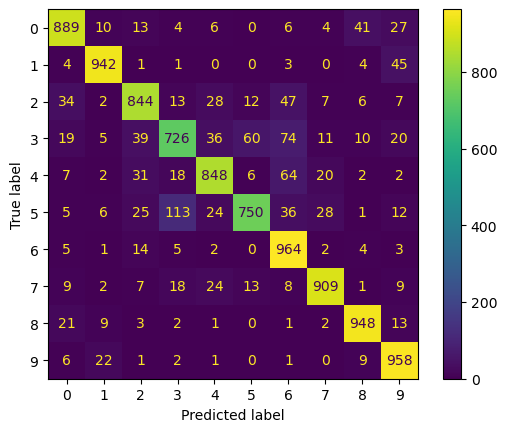

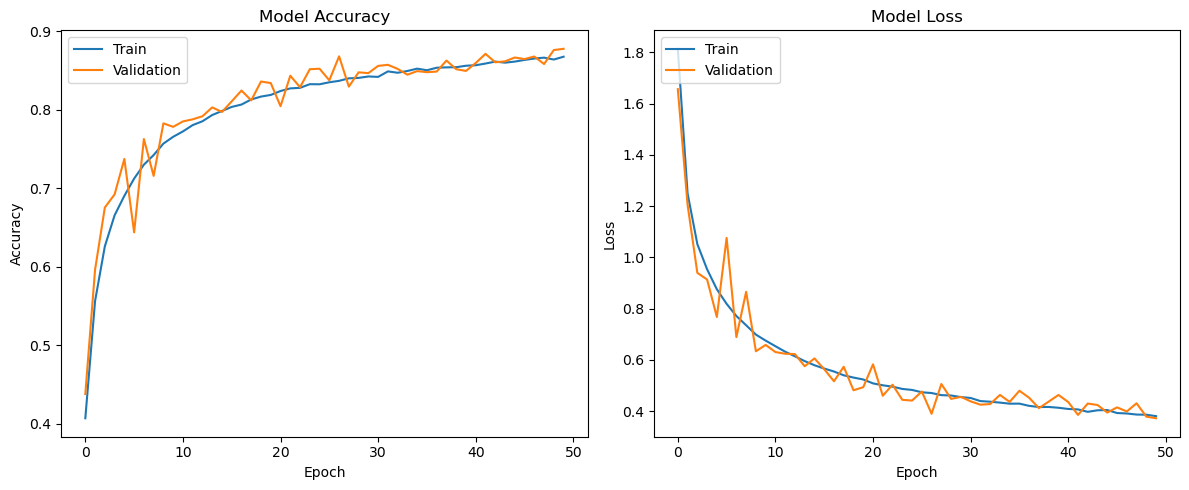

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

def criacaoModeloG9():
    opt=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='elu', input_shape=(32, 32, 3), padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(32, (3, 3), activation='elu', padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), activation='elu', padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(64, (3, 3), activation='elu', padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='elu', padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(128, (3, 3), activation='elu', padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(512, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)
    return model

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

(train_X, train_y), (test_X, test_y) = cifar10.load_data() # Carregar o conjunto de dados # Importar e Treinar
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 32, 3) #padronização e categorização

datagen = ImageDataGenerator(rotation_range=15,horizontal_flip=True,width_shift_range=0.1,height_shift_range=0.1)
datagen.fit(train_X)
    
model = criacaoModeloG9()
inicio = time.time() #tempo de inicio
history=model.fit(datagen.flow(train_X, train_y, batch_size=128),
                    steps_per_epoch = len(train_X) / 128, epochs=50, validation_data=(test_X, test_y))
treinamentoF = time.time() #tempo final
tempoTreino = round(treinamentoF - inicio,2)
print("Tempo de treinamento: ", tempoTreino)
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

  ### [CIFAR]Treinamento e ordem de execução das funções
  * **[Sem seleção de entropia]**
  * **[Dataset Divido na metade e aletatorio]**

Epoch 1/50
195/195 [==============================] - 36s 126ms/step - loss: 2.9634 - accuracy: 0.1034 - val_loss: 2.3312 - val_accuracy: 0.1316
Epoch 2/50
195/195 [==============================] - 24s 121ms/step - loss: 2.5606 - accuracy: 0.0996 - val_loss: 2.2766 - val_accuracy: 0.1360
Epoch 3/50
195/195 [==============================] - 23s 118ms/step - loss: 2.4289 - accuracy: 0.1044 - val_loss: 2.3913 - val_accuracy: 0.0696
Epoch 4/50
195/195 [==============================] - 24s 124ms/step - loss: 2.3878 - accuracy: 0.1011 - val_loss: 2.3069 - val_accuracy: 0.1017
Epoch 5/50
195/195 [==============================] - 24s 121ms/step - loss: 2.3629 - accuracy: 0.0975 - val_loss: 2.2493 - val_accuracy: 0.1551
Epoch 6/50
195/195 [==============================] - 23s 118ms/step - loss: 2.3466 - accuracy: 0.1000 - val_loss: 2.3329 - val_accuracy: 0.1033
Epoch 7/50
195/195 [==============================] - 25s 126ms/step - loss: 2.3466 - accuracy: 0.0988 - val_loss: 2.3269 - val_ac

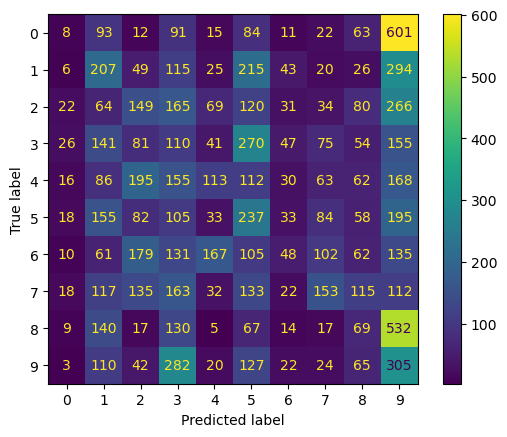

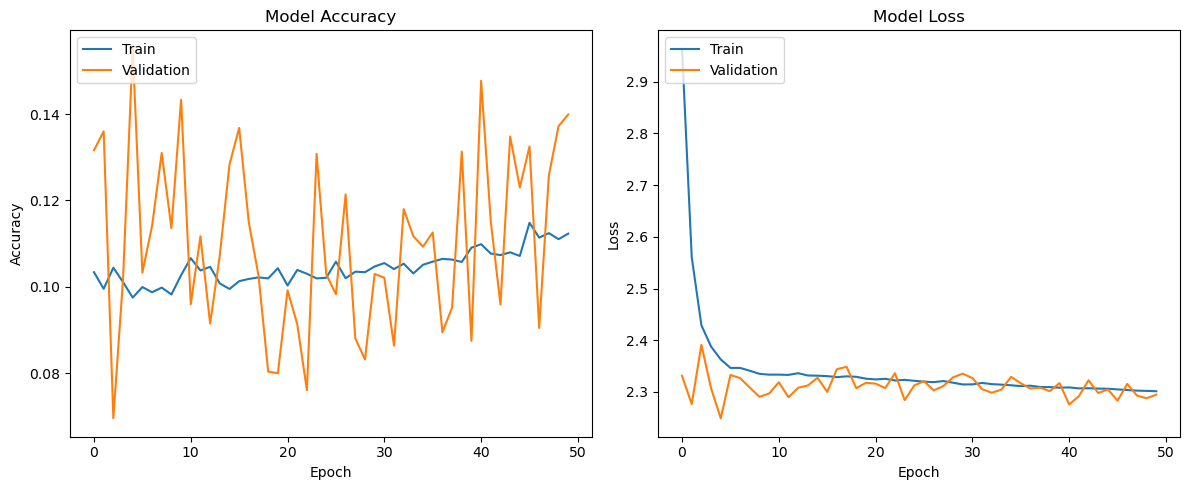

In [7]:
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
import random
def selecionar_metade_aleatoria(metade1, metade2):
    return metade1 if random.choice([True, False]) else metade2

inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = cifar10.load_data() # Carregar o conjunto de dados # Importar e Treinar
metade_train_X, outra_metade_train_X, metade_train_y, outra_metade_train_y = train_test_split(train_X, train_y, test_size=0.5, random_state=42) # Corte aleatorio do dataset na metade
train_X = selecionar_metade_aleatoria(metade_train_X, outra_metade_train_X)
train_y = selecionar_metade_aleatoria(metade_train_y, outra_metade_train_y)

importacaoF = time.time() #tempo de importacao
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 32, 3) #padronização e categorização
datagen = ImageDataGenerator(rotation_range=15,horizontal_flip=True,width_shift_range=0.1,height_shift_range=0.1)
datagen.fit(train_X)
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloG9()
criacaoModeloF = time.time() #tempo de criacao do modelo
history=model.fit(datagen.flow(train_X, train_y, batch_size=128),
                    steps_per_epoch = len(train_X) / 128, epochs=50, validation_data=(test_X, test_y))
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

### [CIFAR]Treinamento e ordem de execução das funções
 * **[Modelo selecionado com entropia]**
 * **[Baixa entropia]**

Epoch 1/50
195/195 [==============================] - 24s 113ms/step - loss: 2.0769 - accuracy: 0.3696 - val_loss: 4.1968 - val_accuracy: 0.1379
Epoch 2/50
195/195 [==============================] - 22s 114ms/step - loss: 1.5158 - accuracy: 0.4795 - val_loss: 1.6079 - val_accuracy: 0.4369
Epoch 3/50
195/195 [==============================] - 21s 108ms/step - loss: 1.2838 - accuracy: 0.5451 - val_loss: 1.1564 - val_accuracy: 0.5883
Epoch 4/50
195/195 [==============================] - 22s 113ms/step - loss: 1.1383 - accuracy: 0.5951 - val_loss: 1.0942 - val_accuracy: 0.6183
Epoch 5/50
195/195 [==============================] - 22s 111ms/step - loss: 1.0572 - accuracy: 0.6236 - val_loss: 1.0996 - val_accuracy: 0.6282
Epoch 6/50
195/195 [==============================] - 22s 111ms/step - loss: 0.9803 - accuracy: 0.6473 - val_loss: 0.9499 - val_accuracy: 0.6782
Epoch 7/50
195/195 [==============================] - 22s 114ms/step - loss: 0.9297 - accuracy: 0.6707 - val_loss: 1.0829 - val_ac

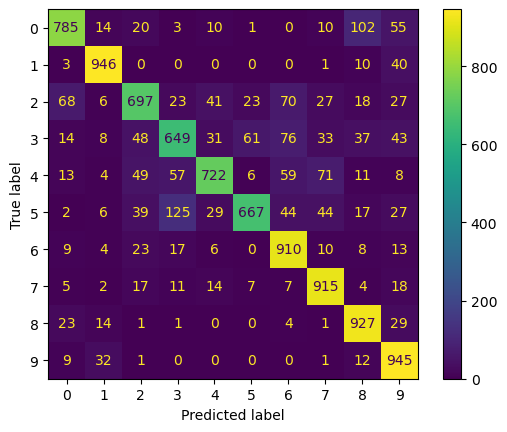

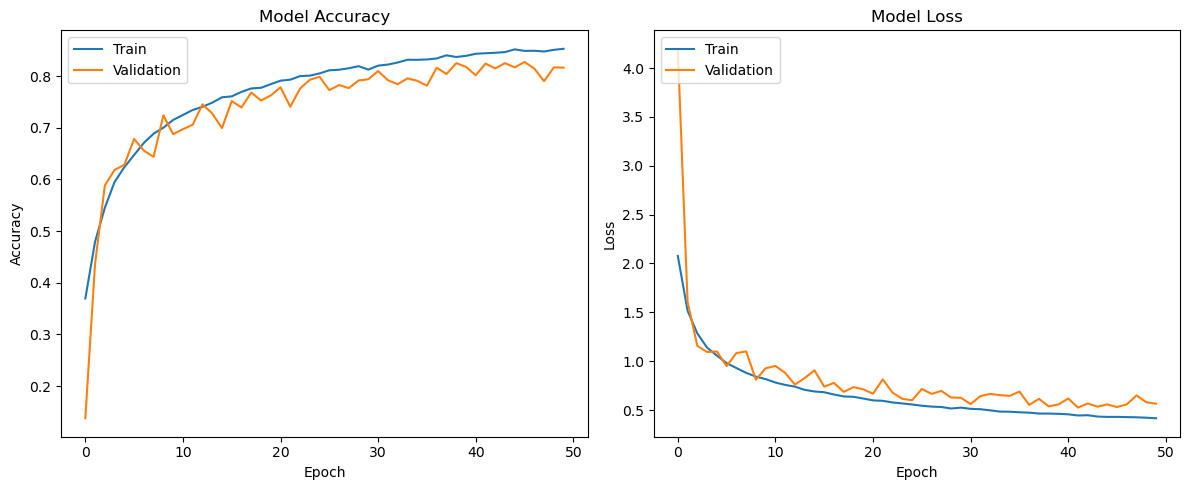

In [9]:
from keras.datasets import cifar10
inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = cifar10.load_data() # Carregar o conjunto de dados # Importar e Treinar
importacaoF = time.time() #tempo de importacao
train_X, train_y = filtrar_entropia_median(train_X, train_y)  #filtro de entropia sob conjunto de dados
entropiaF = time.time() #tempo de filtragem entropia
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 32, 3) #padronização e categorização
datagen = ImageDataGenerator(rotation_range=15,horizontal_flip=True,width_shift_range=0.1,height_shift_range=0.1)
datagen.fit(train_X)
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloG9() # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history=model.fit(datagen.flow(train_X, train_y, batch_size=128),
                    steps_per_epoch = len(train_X) / 128, epochs=50, validation_data=(test_X, test_y))
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

### Filtro de entropia :
  * Dataset filtrado
  * Median transferida para conjunto de treino

Epoch 1/50
195/195 [==============================] - 23s 107ms/step - loss: 2.0825 - accuracy: 0.3662 - val_loss: 4.0463 - val_accuracy: 0.1129
Epoch 2/50
195/195 [==============================] - 26s 133ms/step - loss: 1.5037 - accuracy: 0.4742 - val_loss: 1.6252 - val_accuracy: 0.4392
Epoch 3/50
195/195 [==============================] - 21s 105ms/step - loss: 1.2914 - accuracy: 0.5441 - val_loss: 1.0324 - val_accuracy: 0.6348
Epoch 4/50
195/195 [==============================] - 20s 104ms/step - loss: 1.1386 - accuracy: 0.5929 - val_loss: 1.1398 - val_accuracy: 0.6275
Epoch 5/50
195/195 [==============================] - 21s 105ms/step - loss: 1.0467 - accuracy: 0.6267 - val_loss: 1.0087 - val_accuracy: 0.6528
Epoch 6/50
195/195 [==============================] - 20s 101ms/step - loss: 0.9713 - accuracy: 0.6541 - val_loss: 0.8616 - val_accuracy: 0.6972
Epoch 7/50
195/195 [==============================] - 21s 109ms/step - loss: 0.9225 - accuracy: 0.6716 - val_loss: 0.9215 - val_ac

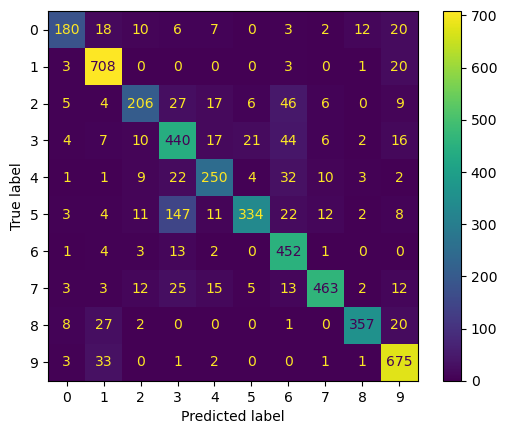

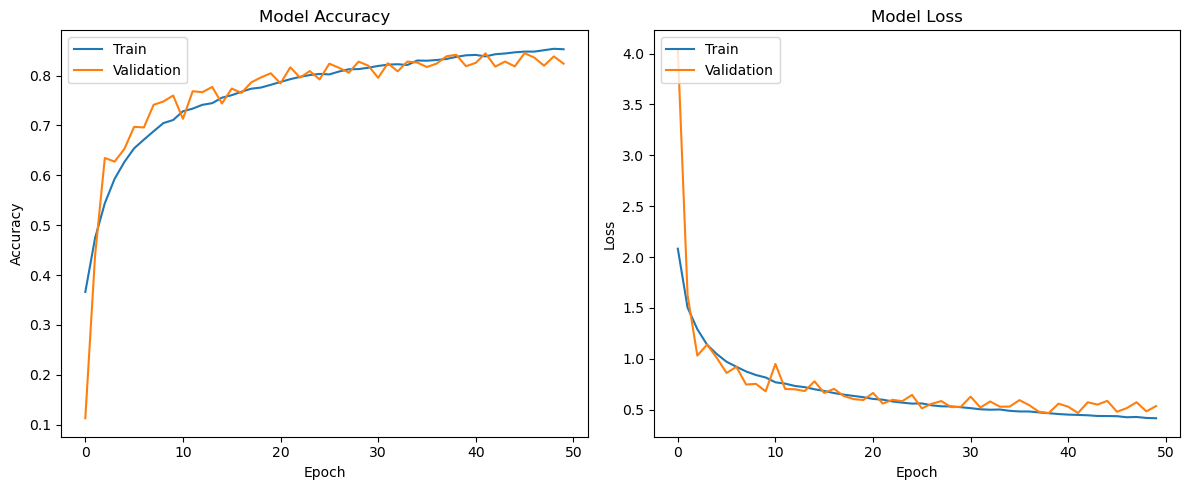

In [10]:
from keras.datasets import cifar10
inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = cifar10.load_data() # Carregar o conjunto de dados # Importar e Treinar
importacaoF = time.time() #tempo de importacao
train_X, train_y, test_X, test_y = filtrar_entropia_median_train_teste(train_X, train_y, test_X, test_y) #novo filtro da reunião 03-10-2023
entropiaF = time.time() #tempo de filtragem entropia
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 32, 3) #padronização e categorização
datagen = ImageDataGenerator(rotation_range=15,horizontal_flip=True,width_shift_range=0.1,height_shift_range=0.1)
datagen.fit(train_X)
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloG9() # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history=model.fit(datagen.flow(train_X, train_y, batch_size=128),
                    steps_per_epoch = len(train_X) / 128, epochs=50, validation_data=(test_X, test_y))
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

### Filtro de entropia :
  * Dataset filtrado
  * Median transferida para conjunto de treino
  * Cross-validation

Treinando a rede no folder numero: 1
Epoch 1/50
195/195 [==============================] - 28s 127ms/step - loss: 2.0689 - accuracy: 0.3688 - val_loss: 4.1414 - val_accuracy: 0.0989
Epoch 2/50
195/195 [==============================] - 22s 115ms/step - loss: 1.4854 - accuracy: 0.4851 - val_loss: 1.4185 - val_accuracy: 0.5033
Epoch 3/50
195/195 [==============================] - 20s 103ms/step - loss: 1.2639 - accuracy: 0.5520 - val_loss: 1.1604 - val_accuracy: 0.6005
Epoch 4/50
195/195 [==============================] - 22s 110ms/step - loss: 1.1257 - accuracy: 0.5969 - val_loss: 1.1456 - val_accuracy: 0.6202
Epoch 5/50
195/195 [==============================] - 20s 102ms/step - loss: 1.0405 - accuracy: 0.6297 - val_loss: 0.9356 - val_accuracy: 0.6817
Epoch 6/50
195/195 [==============================] - 20s 103ms/step - loss: 0.9697 - accuracy: 0.6548 - val_loss: 1.2136 - val_accuracy: 0.6433
Epoch 7/50
195/195 [==============================] - 21s 110ms/step - loss: 0.9163 - accurac

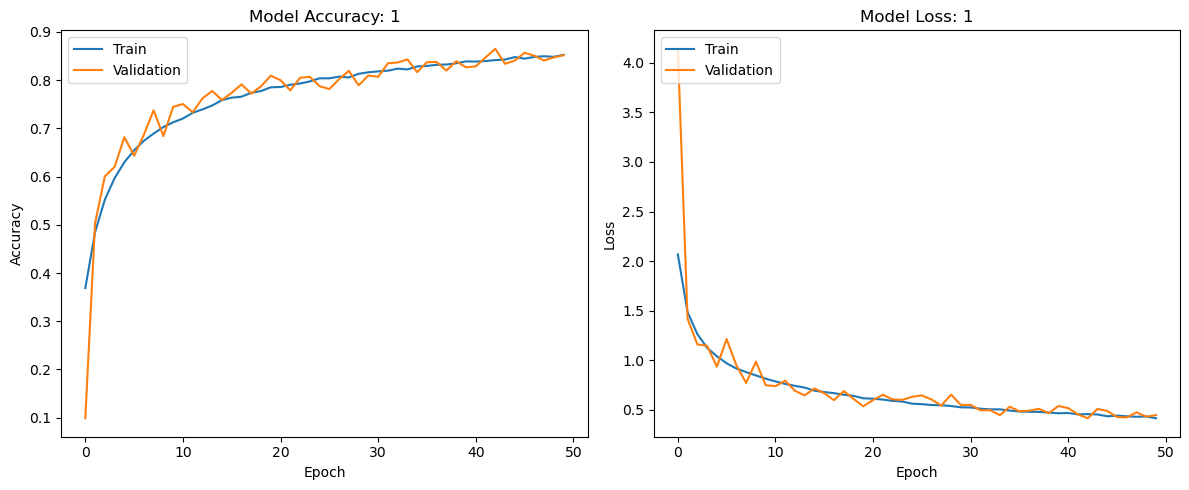

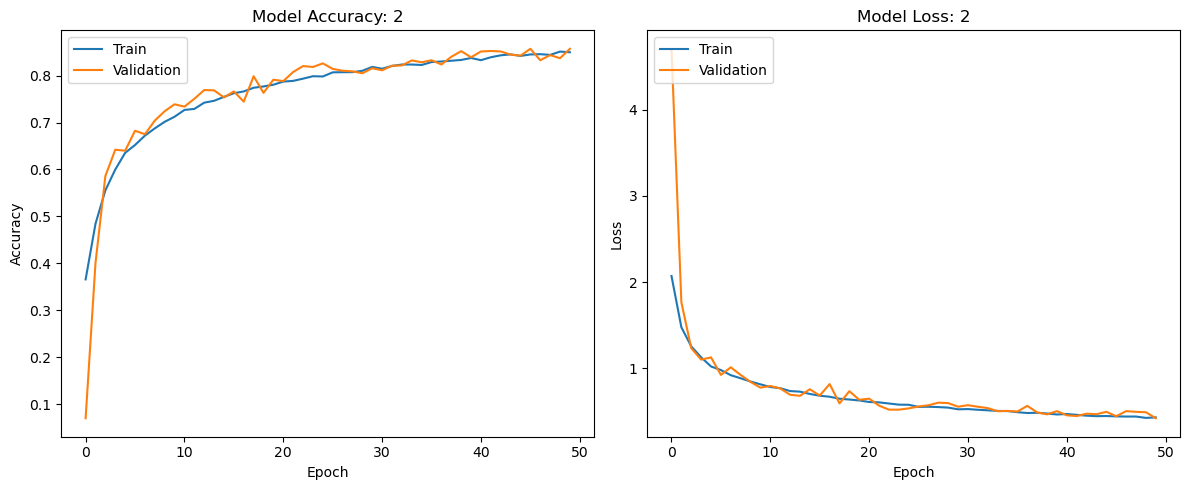

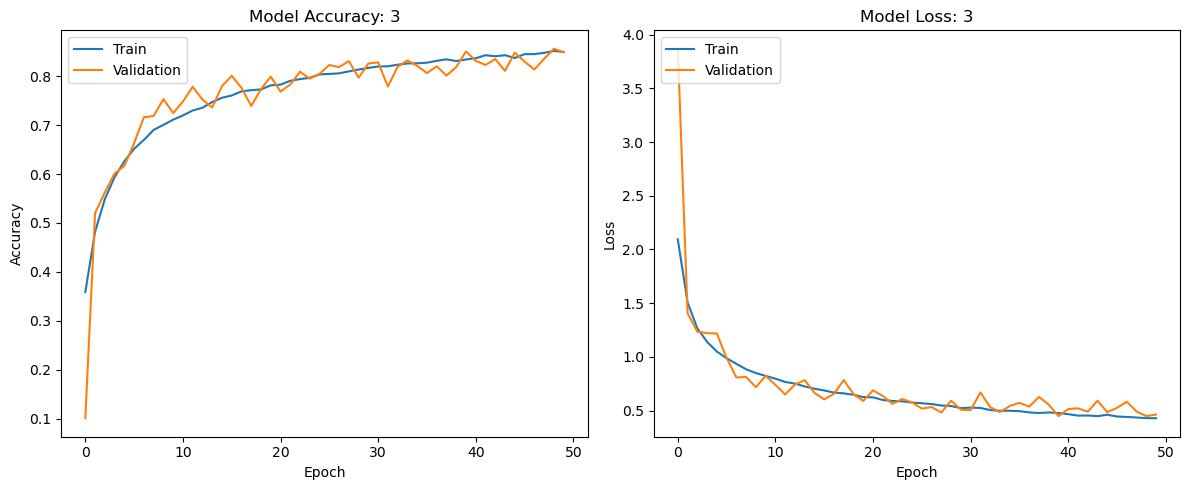

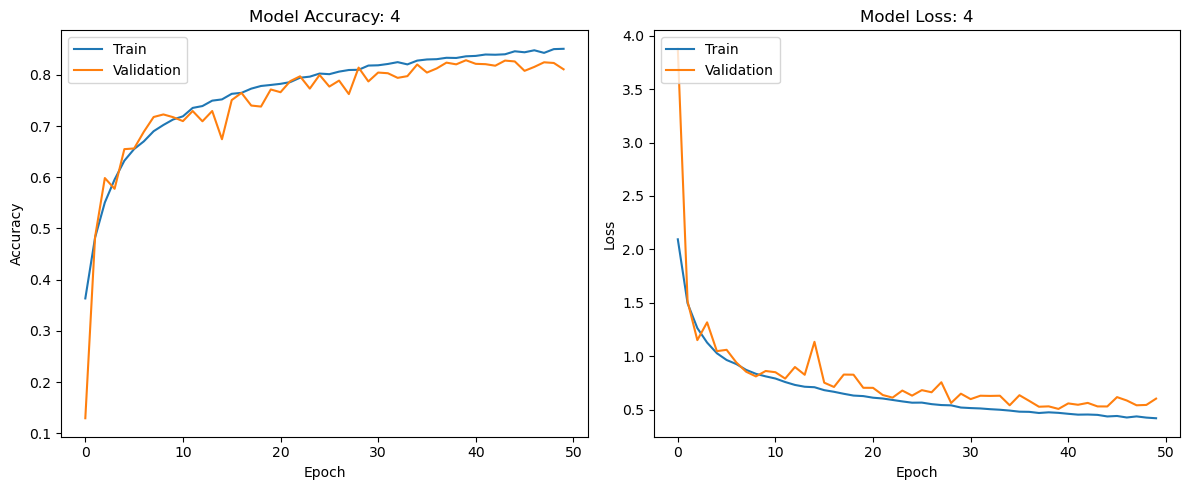

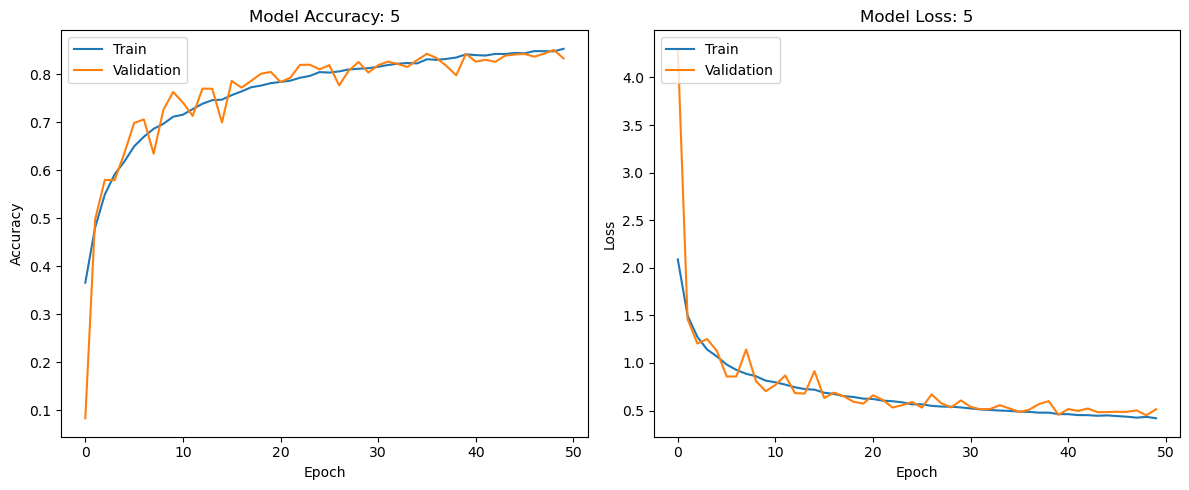

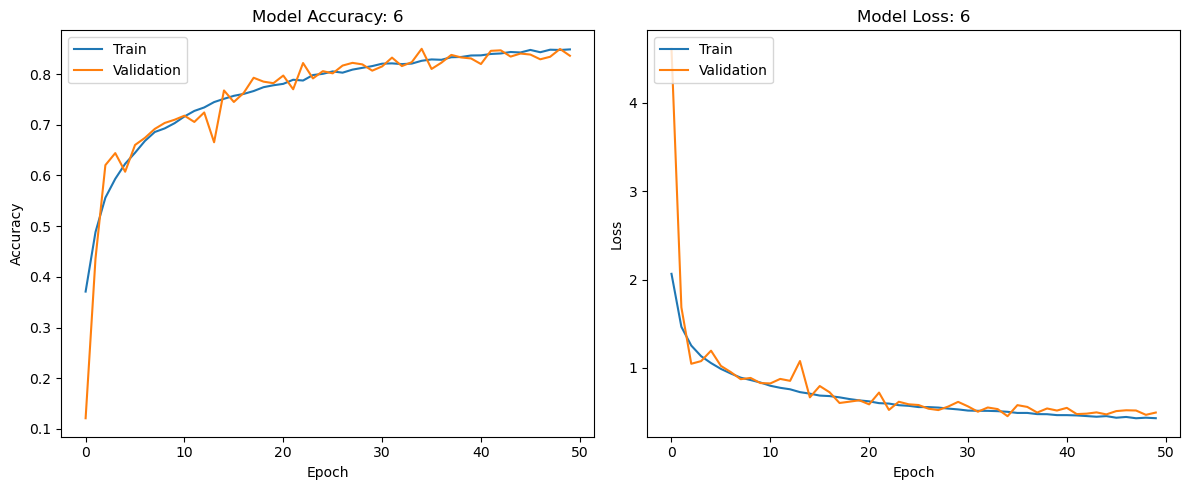

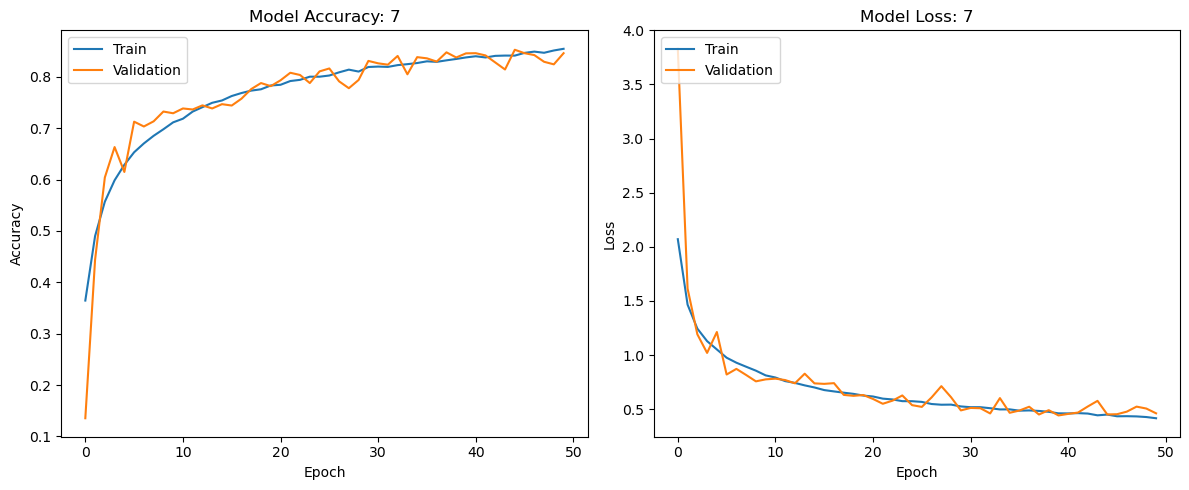

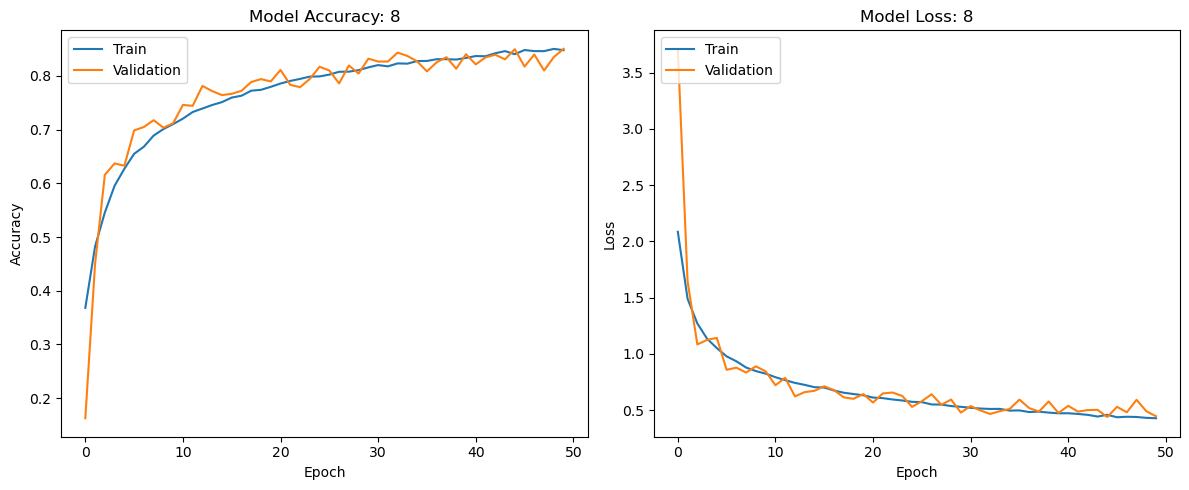

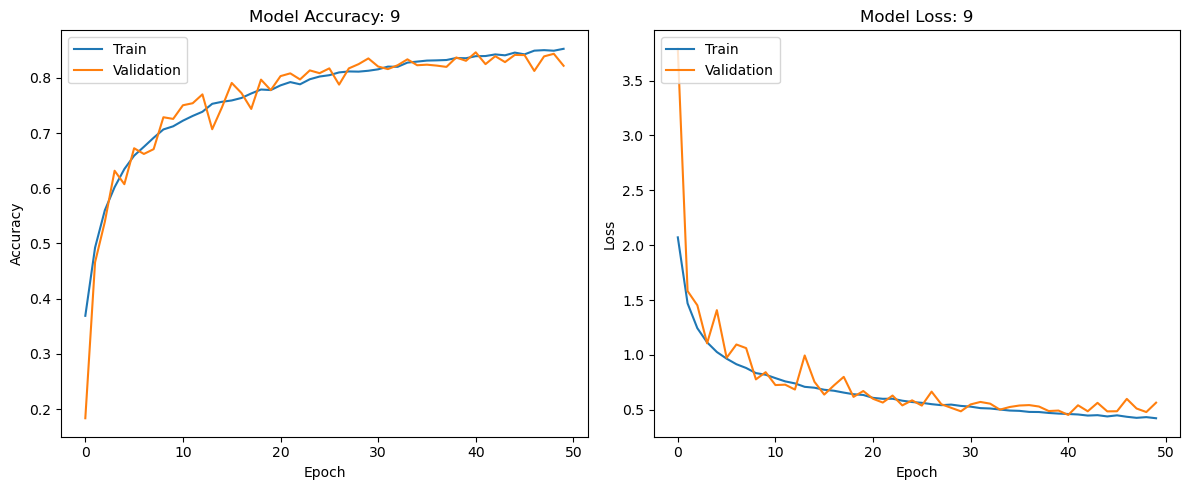

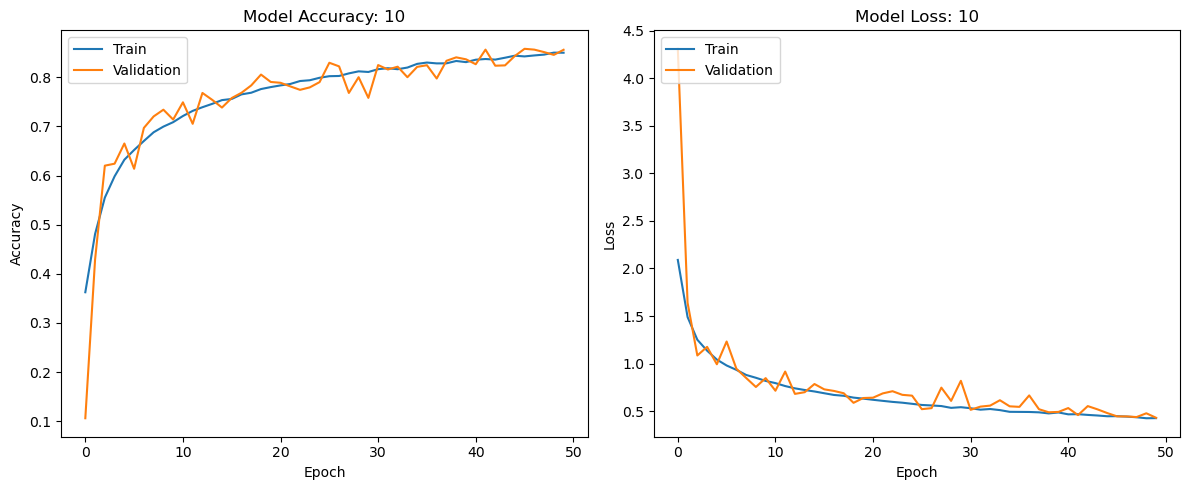

In [13]:
from sklearn.model_selection import KFold

def crossValidation(combinado_treino_X, combinado_validacao_y,n_folds = 5):
    #divide seus dados em k folds, e treina no k−1 e valida em 1 fold, então a proporção de dados usados para validação é 1/k.
    #2 folds (50% de validação): Treina em 50% dos dados e valida nos outros 50%.
    #5 folds (20% de validação): Treina em 80% dos dados e valida em 20%.
    #10 folds (10% de validação): Treina em 90% dos dados e valida em 10%.    
    n_fold = 5 if n_folds == 0 else n_folds
    datagen = ImageDataGenerator(rotation_range=15,horizontal_flip=True,width_shift_range=0.1,height_shift_range=0.1)
    datagen.fit(combinado_treino_X)
    
    kf = KFold(n_splits = n_folds, shuffle = True, random_state = 42)  #divisão do conjunto de dados
    fold_no = 1
    for train, test in kf.split(combinado_treino_X, combinado_validacao_y):
        print(f"Treinando a rede no folder numero: {fold_no}")
        model = criacaoModeloG9() # instanciando o modelo
        inicio = time.time() #tempo de inicio
        history=model.fit(datagen.flow(combinado_treino_X[train], combinado_validacao_y[train], batch_size=128),
                            steps_per_epoch = len(train_X) / 128, epochs=50, validation_data=(combinado_treino_X[test], combinado_validacao_y[test]))        
           
        treinamentoF = time.time() #tempo final
        tempoTreino = round(treinamentoF - inicio,2)
        scores = model.evaluate(combinado_treino_X[test], combinado_validacao_y[test], verbose = 1)
        print(f"Num do Folder: {fold_no}: Taxa de Loss: {scores[0]}, Taxa de Acuracia: {scores[1]*100:.2f}%, Tamanho do Conjunto de Dados: {len(combinado_treino_X[train])}, Tempo de Treino: {tempoTreino}")
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, primeiro gráfico  # Primeiro gráfico (accuracy)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy']) # Métrica de validação
        plt.title(f'Model Accuracy: {fold_no}')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, segundo gráfico # Segundo gráfico (loss)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss']) # Métrica de validação
        plt.title(f'Model Loss: {fold_no}')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.tight_layout() # Exibir os gráficos       
        fold_no += 1
        print("\n")
        
#carregar os dados
from keras.datasets import cifar10
(train_X, train_y), (test_X, test_y) = cifar10.load_data() # Carregar o conjunto de dados # Importar e Treinar
train_X, train_y, test_X, test_y = filtrar_entropia_median_train_teste(train_X, train_y, test_X, test_y) #novo filtro da reunião 03-10-2023
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 32, 3) #carregar preparar
combinado_treino_X = np.concatenate([train_X, test_X], axis=0)
combinado_validacao_y = np.concatenate([train_y, test_y], axis=0)

#criar/instanciar o modelo para validação cruzada
crossValidation(combinado_treino_X,combinado_validacao_y, 10)
